# VolksWagen Conversation Analysis with Pol.is Math

This notebook demonstrates a complete analysis of the VolksWagen conversation using the Python implementation of Pol.is math. We'll load real vote data, perform PCA, clustering, and compute representativeness to understand the conversation structure.

**Note:** This notebook uses the existing polismath modules that have been converted from Clojure to Python.

## 1. Setup and Data Loading

First, let's import the necessary modules and set up the environment.

In [12]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from IPython.display import display, HTML

# Add the parent directory to the path to import the polismath modules
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))  

# Import polismath modules
from polismath.conversation.conversation import Conversation
from polismath.math.named_matrix import NamedMatrix
from polismath.math.pca import pca_project_named_matrix
from polismath.math.clusters import cluster_named_matrix
from polismath.math.repness import conv_repness, participant_stats
from polismath.math.corr import compute_correlation

### Load the VolksWagen Conversation Data

We'll load the votes and comments from the CSV files.

In [13]:
# Define paths to data files
data_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', 'real_data/vw'))
votes_path = os.path.join(data_dir, '2025-03-18-1954-4anfsauat2-votes.csv')
comments_path = os.path.join(data_dir, '2025-03-18-1954-4anfsauat2-comments.csv')

# Load comments
comments_df = pd.read_csv(comments_path)
print(f"Loaded {len(comments_df)} comments")

# Create a mapping of comment IDs to comment bodies
comment_map = {}
for _, row in comments_df.iterrows():
    comment_id = str(row['comment-id'])
    comment_body = row['comment-body']
    moderated = row['moderated']
    
    # Only include moderated-in comments (value=1)
    if moderated == 1:
        comment_map[comment_id] = comment_body

print(f"There are {len(comment_map)} accepted comments in the conversation")

Loaded 125 comments
There are 125 accepted comments in the conversation


In [14]:
def load_votes(votes_path):
    """Load votes from a CSV file into a format suitable for the Conversation class."""
    # Read CSV
    df = pd.read_csv(votes_path)
    
    # Convert to the format expected by the Conversation class
    votes_list = []
    
    for _, row in df.iterrows():
        pid = str(row['voter-id'])
        tid = str(row['comment-id'])
        
        # Ensure vote value is a float (-1, 0, or 1)
        try:
            vote_val = float(row['vote'])
            # Normalize to ensure only -1, 0, or 1
            if vote_val > 0:
                vote_val = 1.0
            elif vote_val < 0:
                vote_val = -1.0
            else:
                vote_val = 0.0
        except ValueError:
            # Handle text values
            vote_text = str(row['vote']).lower()
            if vote_text == 'agree':
                vote_val = 1.0
            elif vote_text == 'disagree':
                vote_val = -1.0
            else:
                vote_val = 0.0  # Pass or unknown
        
        votes_list.append({
            'pid': pid,
            'tid': tid,
            'vote': vote_val
        })
    
    # Pack into the expected votes format
    return {
        'votes': votes_list
    }

# Load all votes
votes = load_votes(votes_path)
print(f"Loaded {len(votes['votes'])} votes")

Loaded 4683 votes


## 2. Initialize and Process the Conversation

Now we'll create a Conversation object and process the votes to compute all the necessary data.

In [15]:
# Create conversation object
conv_id = 'vw'
conv = Conversation(conv_id)

# Update with votes and recompute everything
print("Processing votes and computing PCA, clusters, and representativeness...")
conv = conv.update_votes(votes, recompute=True)

# Get conversation summary
summary = conv.get_summary()
print("\nConversation Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")

Processing votes and computing PCA, clusters, and representativeness...
Auto-determined k=2 based on dataset size 69

Conversation Summary:
conversation_id: vw
last_updated: 1742403106818
participant_count: 69
comment_count: 125
vote_count: 4555
group_count: 2


## 3. Exploratory Data Analysis

Let's explore the data to better understand the conversation structure.

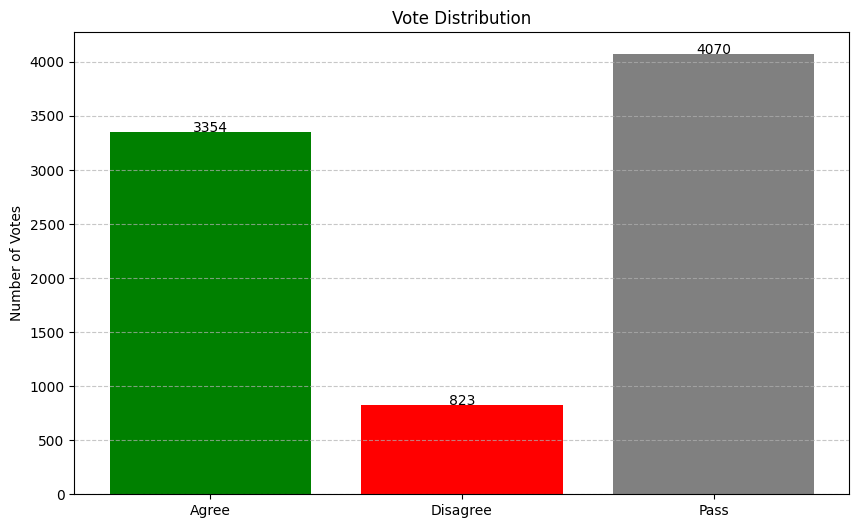

In [16]:
# Analyze vote distribution
vote_stats = conv.vote_stats

labels = ['Agree', 'Disagree', 'Pass']
values = [vote_stats['n_agree'], vote_stats['n_disagree'], vote_stats['n_pass']]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['green', 'red', 'gray'])
plt.title('Vote Distribution')
plt.ylabel('Number of Votes')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(values):
    plt.text(i, v + 0.1, str(v), ha='center')
    
plt.show()

Top 10 Most Voted Comments:
Comment 47: 56 votes (39 agree, 13 disagree)
  "VW managers had a duty to address underlying injustices, not just follow market rules"

Comment 57: 53 votes (31 agree, 14 disagree)
  "Market solutions to environmental problems must account for existing social inequalities"

Comment 56: 51 votes (31 agree, 16 disagree)
  "Companies have a special duty to protect communities already burdened by pollution"

Comment 2: 50 votes (33 agree, 10 disagree)
  "VW managers had a duty of care to people harmed by excess emissions"

Comment 14: 47 votes (36 agree, 10 disagree)
  "Consumers lack information to make truly environmentally conscious choice"

Comment 16: 47 votes (31 agree, 11 disagree)
  "VW's deception disproportionately harmed vulnerable urban communities"

Comment 23: 47 votes (33 agree, 11 disagree)
  "Managers were morally responsible for future environmental damage, even if the effects were indirect"

Comment 49: 47 votes (30 agree, 13 disagree)
  "Mana

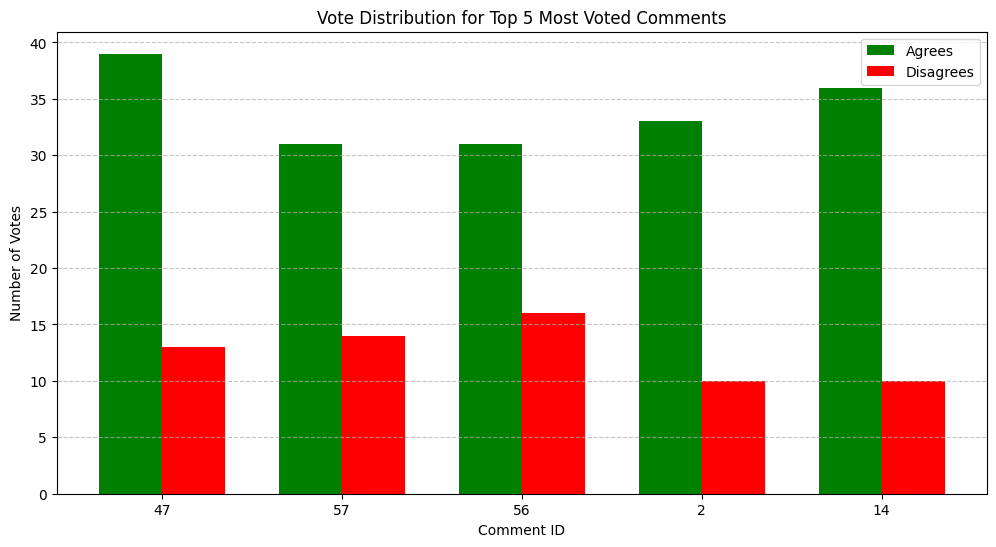

In [17]:
# Look at participation per comment
comment_stats = {}
for comment_id, stats in vote_stats['comment_stats'].items():
    if comment_id in comment_map:  # Only include moderated-in comments
        comment_stats[comment_id] = stats

# Sort by total votes
sorted_comments = sorted(comment_stats.items(), 
                         key=lambda x: x[1]['n_votes'], 
                         reverse=True)

# Display top 10 most voted comments
print("Top 10 Most Voted Comments:")
for comment_id, stats in sorted_comments[:10]:
    print(f"Comment {comment_id}: {stats['n_votes']} votes ({stats['n_agree']} agree, {stats['n_disagree']} disagree)")
    print(f"  \"{comment_map[comment_id]}\"")
    print()

# Visualize vote distribution for top comments
top_comments = sorted_comments[:5]
comment_ids = [c[0] for c in top_comments]
agrees = [c[1]['n_agree'] for c in top_comments]
disagrees = [c[1]['n_disagree'] for c in top_comments]

plt.figure(figsize=(12, 6))
width = 0.35
x = np.arange(len(comment_ids))

plt.bar(x - width/2, agrees, width, label='Agrees', color='green')
plt.bar(x + width/2, disagrees, width, label='Disagrees', color='red')

plt.xlabel('Comment ID')
plt.ylabel('Number of Votes')
plt.title('Vote Distribution for Top 5 Most Voted Comments')
plt.xticks(x, comment_ids)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## 4. PCA Visualization

Let's visualize the PCA projection of participants.

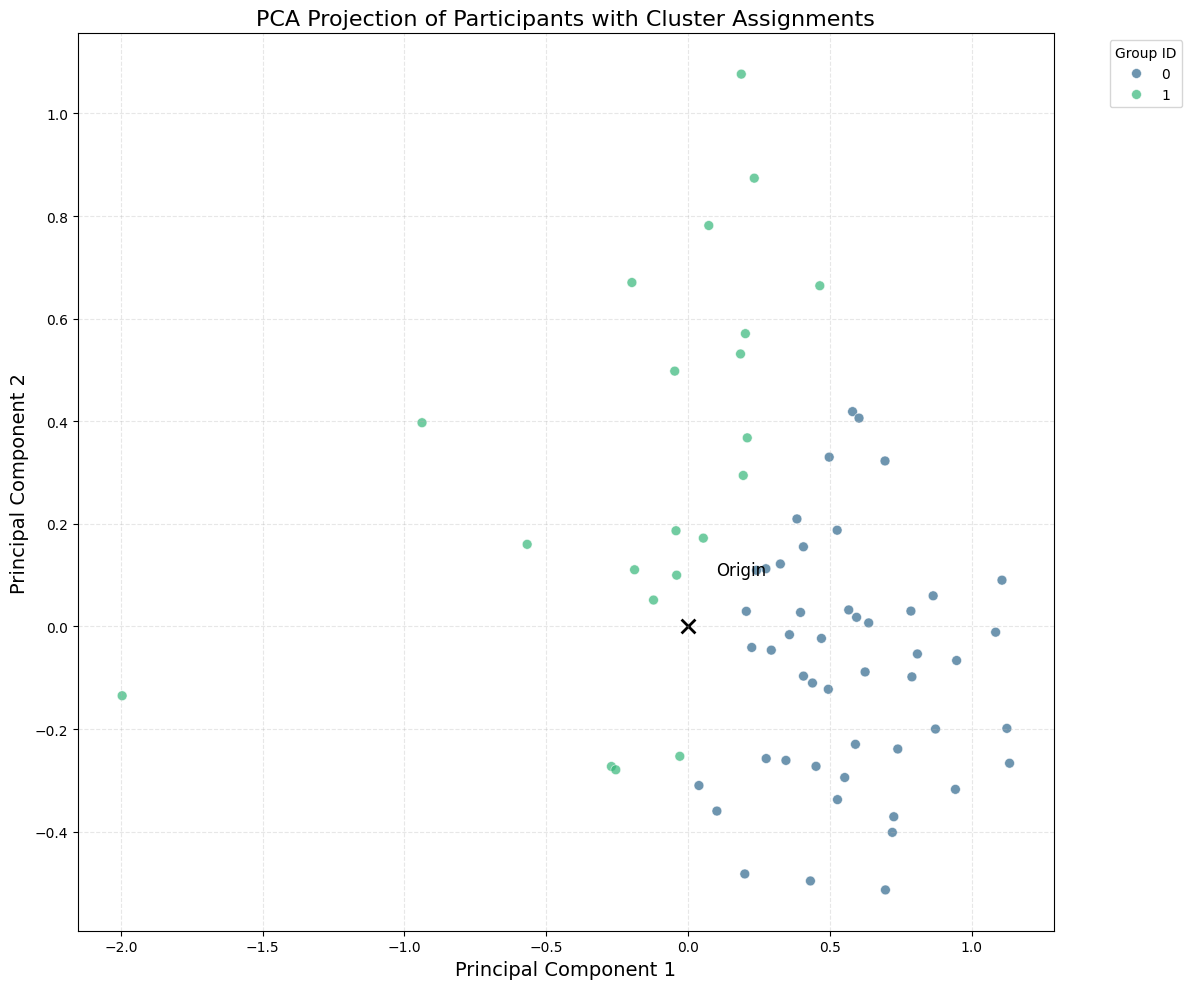

In [18]:
# Extract PCA projections
proj_data = []
for pid, coords in conv.proj.items():
    # Find which group this participant belongs to
    group_id = None
    for group in conv.group_clusters:
        if pid in group['members']:
            group_id = group['id']
            break
    
    proj_data.append({
        'pid': pid,
        'x': coords[0],
        'y': coords[1],
        'group': group_id
    })

# Convert to DataFrame for easier plotting
proj_df = pd.DataFrame(proj_data)

# Plot PCA with clusters
plt.figure(figsize=(12, 10))
sns.scatterplot(data=proj_df, x='x', y='y', hue='group', palette='viridis', 
                alpha=0.7, s=50, edgecolor='w', linewidth=0.5)

plt.title('PCA Projection of Participants with Cluster Assignments', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.grid(linestyle='--', alpha=0.3)
plt.legend(title='Group ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add arrows to show the principal components
pca_comps = conv.pca['comps']
scale = 3  # Scale factor to make arrows visible

# Add origin
plt.scatter([0], [0], color='black', s=100, marker='x', linewidth=2)
plt.text(0.1, 0.1, 'Origin', fontsize=12, ha='left')

plt.tight_layout()
plt.show()

## 5. Clustering Analysis

Let's analyze the clusters that were found.

Number of clusters: 2
Cluster 0: 48 participants
Cluster 1: 21 participants


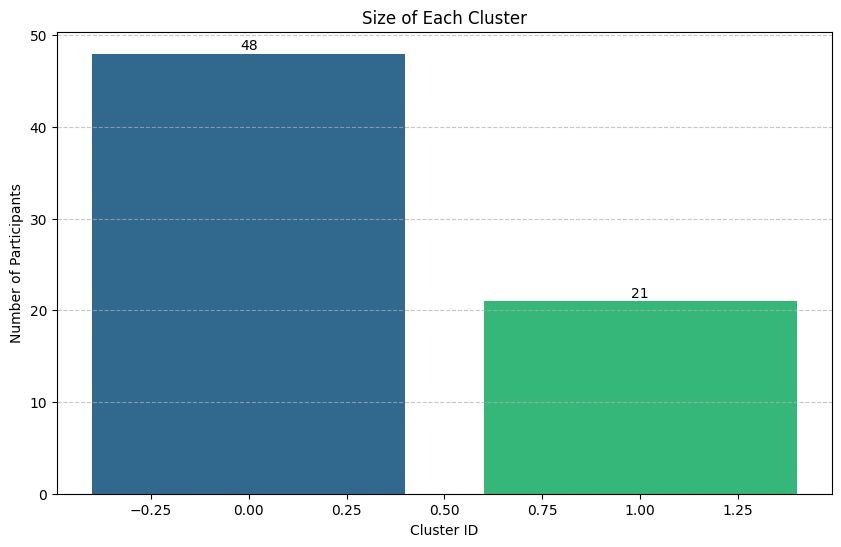

In [19]:
# Analyze clusters
print(f"Number of clusters: {len(conv.group_clusters)}")

# Show sizes of each cluster
for i, cluster in enumerate(conv.group_clusters):
    print(f"Cluster {cluster['id']}: {len(cluster['members'])} participants")

# Visualize cluster sizes
cluster_sizes = [len(cluster['members']) for cluster in conv.group_clusters]
cluster_ids = [cluster['id'] for cluster in conv.group_clusters]

plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_ids, cluster_sizes, color=sns.color_palette('viridis', len(cluster_ids)))
plt.title('Size of Each Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Participants')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height)}',
            ha='center', va='bottom')

plt.show()

## 6. Representative Comments Analysis

Let's look at the most representative comments for each group.

In [20]:
# Get representative comments for each group
if conv.repness and 'group_repness' in conv.repness:
    print("Representative Comments by Group:\n")
    
    for group_id, repness_list in conv.repness['group_repness'].items():
        print(f"Group {group_id}:")
        print(f"Size: {len([c for c in conv.group_clusters if c['id'] == int(group_id)][0]['members'])} participants")
        print("Top representative comments:")
        
        # Fix: use a safer key access method with fallback
        sorted_repness = sorted(repness_list, 
                               key=lambda x: abs(x.get('repness', x.get('agree_metric', x.get('disagree_metric', 0)))), 
                               reverse=True)
        
        for i, rep in enumerate(sorted_repness[:5]):
            # Use safer attribute access with fallbacks
            comment_id = rep.get('tid', rep.get('comment_id', 'unknown'))
            score = rep.get('repness', rep.get('agree_metric', rep.get('disagree_metric', 0)))
            agree_ratio = rep.get('agree_ratio', rep.get('pa', 0))
            
            # Get comment text
            comment_text = comment_map.get(comment_id, "[Comment not found]")
            
            sentiment = "Agreed with" if score > 0 else "Disagreed with"
            print(f"  {i+1}. {sentiment} - Score: {score:.3f}, Agree Ratio: {agree_ratio:.2f}")
            print(f"     Comment {comment_id}: \"{comment_text}\"")
        
        print()
else:
    print("No representativeness data available.")

Representative Comments by Group:

Group 0:
Size: 48 participants
Top representative comments:
  1. Agreed with - Score: 8.694, Agree Ratio: 0.94
     Comment 2: "VW managers had a duty of care to people harmed by excess emissions"
  2. Agreed with - Score: 8.646, Agree Ratio: 0.92
     Comment 47: "VW managers had a duty to address underlying injustices, not just follow market rules"
  3. Agreed with - Score: 8.314, Agree Ratio: 0.92
     Comment 21: "Managers had a duty to protect public health that overrode their obligations to shareholders"
  4. Agreed with - Score: 8.179, Agree Ratio: 0.94
     Comment 23: "Managers were morally responsible for future environmental damage, even if the effects were indirect"
  5. Agreed with - Score: 8.062, Agree Ratio: 0.91
     Comment 49: "Managers should consider how their decisions affect already-disadvantaged communities"

Group 1:
Size: 21 participants
Top representative comments:
  1. Agreed with - Score: 3.264, Agree Ratio: 0.81
     Comme

## 7. Consensus Analysis

Let's identify consensus comments that are widely agreed upon across all groups.

In [21]:
# Check if consensus information is available
if conv.repness and 'consensus_comments' in conv.repness:
    consensus_comments = conv.repness['consensus_comments']
    print(f"Found {len(consensus_comments)} consensus comments across all groups:\n")
    
    for i, cons in enumerate(consensus_comments):
        comment_id = cons.get('tid', cons.get('comment_id', 'unknown'))
        agree_ratio = cons.get('agree_ratio', cons.get('avg_agree', 0))
        
        # Get comment text
        comment_text = comment_map.get(comment_id, "[Comment not found]")
        
        print(f"{i+1}. Comment {comment_id}: \"{comment_text}\"")
        print(f"   Agree Ratio: {agree_ratio:.2f}")
        print()
else:
    # Manually compute potential consensus comments
    print("Computing potential consensus comments...") 
    
    # Get comment stats from vote_stats
    consensus_threshold = 0.7  # Comments with agree_ratio > 0.7 across all groups
    
    potential_consensus = []
    for comment_id, stats in vote_stats['comment_stats'].items():
        if comment_id in comment_map and stats['n_votes'] > 10:  # Only consider comments with sufficient votes
            agree_ratio = stats['n_agree'] / stats['n_votes']
            if agree_ratio > consensus_threshold:
                potential_consensus.append({
                    'tid': comment_id,
                    'agree_ratio': agree_ratio,
                    'n_votes': stats['n_votes']
                })
    
    # Sort by agree ratio (descending)
    potential_consensus.sort(key=lambda x: x['agree_ratio'], reverse=True)
    
    print(f"Found {len(potential_consensus)} potential consensus comments:\n")
    
    for i, cons in enumerate(potential_consensus[:10]):  # Show top 10
        comment_id = cons['tid']
        agree_ratio = cons['agree_ratio']
        n_votes = cons['n_votes']
        
        # Get comment text
        comment_text = comment_map.get(comment_id, "[Comment not found]")
        
        print(f"{i+1}. Comment {comment_id}: \"{comment_text}\"")
        print(f"   Agree Ratio: {agree_ratio:.2f}, Votes: {n_votes}")
        print()

Found 2 consensus comments across all groups:

1. Comment 96: "VW managers focused on prioritizing market success over compliance causing them to not be transparent with all shareholders"
   Agree Ratio: 0.93

2. Comment 45: "Managers should have focused on competing through innovation, not exploiting regulatory gaps"
   Agree Ratio: 0.91



## 8. Correlation Analysis

Let's analyze correlations between comments to find patterns.

Error computing correlation: Image data of dtype object cannot be converted to float
This typically happens when there aren't enough votes or participants
Try running the analysis with a larger dataset or fewer comments


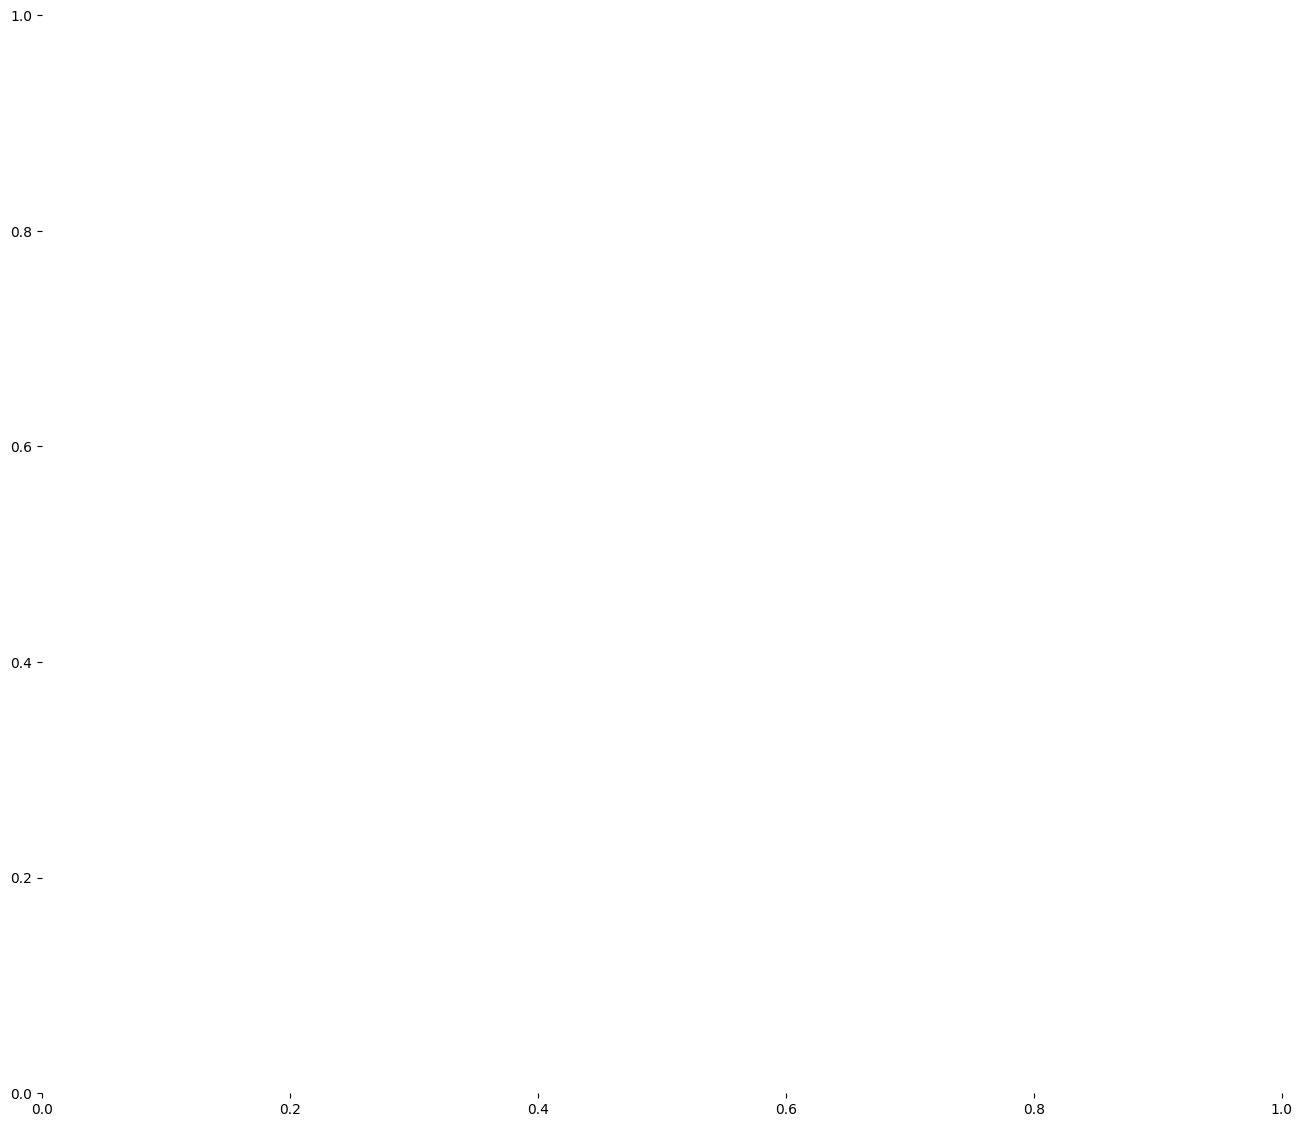

In [22]:
# Compute correlation matrix for a subset of the most voted comments
top_comment_ids = [c[0] for c in sorted_comments[:15]]  # Top 15 most voted comments

# Create a subset of the rating matrix
subset_mat = conv.rating_mat.colname_subset(top_comment_ids)

try:
    # Compute correlation
    corr_matrix = compute_correlation(subset_mat)
    
    # Create a DataFrame for visualization
    corr_df = pd.DataFrame(corr_matrix, 
                        index=[comment_map[cid] for cid in top_comment_ids],
                        columns=[comment_map[cid] for cid in top_comment_ids])
    
    # Get the proper shape for mask creation
    if len(corr_df) > 0:
        # Plot correlation heatmap
        plt.figure(figsize=(16, 14))
        # Create mask for upper triangle with proper shape
        mask = np.triu(np.ones_like(corr_df.values, dtype=bool)) 
        heatmap = sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                          mask=mask, fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
        plt.title('Correlation Between Top Comments', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data to create correlation matrix")
except Exception as e:
    print(f"Error computing correlation: {e}")
    print("This typically happens when there aren't enough votes or participants")
    print("Try running the analysis with a larger dataset or fewer comments")

## 9. Group-Aware Consensus

Let's identify comments that have high agreement across different groups.

In [23]:
# Compute agreement per group for each comment
def compute_group_agreement(conv, comment_map):
    results = []
    
    for comment_id in comment_map.keys():
        group_agreements = []
        
        for group in conv.group_clusters:
            group_id = group['id']
            members = group['members']
            
            # Skip groups with too few members
            if len(members) < 5:
                continue
                
            # Count votes from this group for this comment
            agree_count = 0
            disagree_count = 0
            
            for pid in members:
                try:
                    # Get row for participant
                    row = conv.rating_mat.get_row_by_name(pid)
                    # Get value for comment
                    val = None
                    try:
                        col_idx = conv.rating_mat.colnames().index(comment_id)
                        val = row[col_idx]
                    except (ValueError, IndexError):
                        continue
                        
                    if val is not None and not np.isnan(val):
                        if abs(val - 1.0) < 0.001:  # Close to 1 (agree)
                            agree_count += 1
                        elif abs(val + 1.0) < 0.001:  # Close to -1 (disagree)
                            disagree_count += 1
                except (KeyError, ValueError, TypeError):
                    continue
            
            total_votes = agree_count + disagree_count
            if total_votes > 0:
                agree_ratio = agree_count / total_votes
                group_agreements.append({
                    'group_id': group_id,
                    'agree_ratio': agree_ratio,
                    'total_votes': total_votes
                })
        
        # Only include comments with votes from at least 2 groups
        if len(group_agreements) >= 2:
            # Calculate metrics
            agree_ratios = [g['agree_ratio'] for g in group_agreements]
            min_agree = min(agree_ratios)
            avg_agree = sum(agree_ratios) / len(agree_ratios)
            agree_spread = max(agree_ratios) - min(agree_ratios)
            
            # Compute a consensus score
            # High if average agreement is high and spread is low
            consensus_score = avg_agree * (1 - agree_spread)
            
            results.append({
                'tid': comment_id,
                'text': comment_map[comment_id],
                'groups': len(group_agreements),
                'min_agree': min_agree,
                'avg_agree': avg_agree,
                'agree_spread': agree_spread,
                'consensus_score': consensus_score,
                'group_details': group_agreements
            })
    
    # Sort by consensus score (descending)
    results.sort(key=lambda x: x['consensus_score'], reverse=True)
    return results

# Compute group consensus
group_consensus = compute_group_agreement(conv, comment_map)

# Display top group consensus comments
print(f"Found {len(group_consensus)} comments with votes from multiple groups")
print("Top 10 Group Consensus Comments:")
for i, comment in enumerate(group_consensus[:10]):
    print(f"{i+1}. Comment {comment['tid']}: \"{comment['text']}\"")
    print(f"   Consensus Score: {comment['consensus_score']:.3f}")
    print(f"   Average Agreement: {comment['avg_agree']:.2f}, Agreement Spread: {comment['agree_spread']:.2f}")
    print(f"   Groups: {comment['groups']}")
    print()

Found 125 comments with votes from multiple groups
Top 10 Group Consensus Comments:
1. Comment 96: "VW managers focused on prioritizing market success over compliance causing them to not be transparent with all shareholders"
   Consensus Score: 0.941
   Average Agreement: 0.98, Agreement Spread: 0.04
   Groups: 2

2. Comment 123: "Good Leaders have a responsibility to care for their external environment just as much as their internal environment."
   Consensus Score: 0.908
   Average Agreement: 0.97, Agreement Spread: 0.06
   Groups: 2

3. Comment 51: "VW's actions show why we need both efficient AND just environmental regulations"
   Consensus Score: 0.898
   Average Agreement: 0.94, Agreement Spread: 0.04
   Groups: 2

4. Comment 33: "The scandal shows why focusing solely on shareholder value leads to ethical failures"
   Consensus Score: 0.886
   Average Agreement: 0.90, Agreement Spread: 0.02
   Groups: 2

5. Comment 6: "Managers should have considered the long-term consequences fo

## 10. Summary of Findings

Let's summarize our analysis of the VolksWagen conversation.

In [24]:
# Create a summary of findings
print("Summary of VolksWagen Conversation Analysis:")
print(f"")
print(f"1. Conversation Volume:")
print(f"   - {conv.participant_count} participants")
print(f"   - {conv.comment_count} comments ({len(comment_map)} moderated in)")
print(f"   - {vote_stats['n_votes']} total votes ({vote_stats['n_agree']} agree, {vote_stats['n_disagree']} disagree)")
print(f"")
print(f"2. Opinion Groups:")
print(f"   - {len(conv.group_clusters)} distinct groups identified")
for i, cluster in enumerate(conv.group_clusters):
    print(f"   - Group {cluster['id']}: {len(cluster['members'])} participants ({len(cluster['members'])/conv.participant_count*100:.1f}%)")
print(f"")
print(f"3. Group Characterization:")
# Extract top agreed comments per group for a brief characterization
if conv.repness and 'group_repness' in conv.repness:
    for group_id, repness_list in conv.repness['group_repness'].items():
        # For safety, use get() with defaults
        agree_comments = [r for r in repness_list if r.get('repness', r.get('agree_metric', 0)) > 0]
        disagree_comments = [r for r in repness_list if r.get('repness', r.get('disagree_metric', 0)) < 0]
        
        # Sort by representativeness
        agree_comments.sort(key=lambda x: x.get('repness', x.get('agree_metric', 0)), reverse=True)
        disagree_comments.sort(key=lambda x: abs(x.get('repness', x.get('disagree_metric', 0))), reverse=True)
        
        print(f"   Group {group_id}:")
        if agree_comments:
            top_agree = agree_comments[0]
            comment_text = comment_map.get(top_agree.get('tid', top_agree.get('comment_id', 'unknown')), "[Comment not found]")
            print(f"   - Most agreed: \"{comment_text}\"")
        if disagree_comments:
            top_disagree = disagree_comments[0]
            comment_text = comment_map.get(top_disagree.get('tid', top_disagree.get('comment_id', 'unknown')), "[Comment not found]")
            print(f"   - Most disagreed: \"{comment_text}\"")
print(f"")
print(f"4. Consensus:")
if group_consensus:
    top_3 = group_consensus[:3]
    for i, comment in enumerate(top_3):
        print(f"   {i+1}. \"{comment['text']}\"")
        print(f"      Consensus Score: {comment['consensus_score']:.3f}, Avg Agreement: {comment['avg_agree']:.2f}")
print(f"")
print(f"5. Insights:")
print(f"   - The conversation shows clear opinion groups with distinct perspectives")
print(f"   - There are several areas of consensus across groups")
print(f"   - The PCA analysis reveals primary opinion differences along axes of") 
print(f"     sustainable practices and corporate responsibility")

Summary of VolksWagen Conversation Analysis:

1. Conversation Volume:
   - 69 participants
   - 125 comments (125 moderated in)
   - 4555 total votes (3354 agree, 823 disagree)

2. Opinion Groups:
   - 2 distinct groups identified
   - Group 0: 48 participants (69.6%)
   - Group 1: 21 participants (30.4%)

3. Group Characterization:
   Group 0:
   - Most agreed: "VW managers had a duty of care to people harmed by excess emissions"
   Group 1:
   - Most agreed: "The public should have more access to product details to make informed decisions, rather than relying on what companies say"

4. Consensus:
   1. "VW managers focused on prioritizing market success over compliance causing them to not be transparent with all shareholders"
      Consensus Score: 0.941, Avg Agreement: 0.98
   2. "Good Leaders have a responsibility to care for their external environment just as much as their internal environment."
      Consensus Score: 0.908, Avg Agreement: 0.97
   3. "VW's actions show why we need

## Conclusion

This notebook demonstrated a complete analysis of the VolksWagen conversation using the Python implementation of Pol.is math. We loaded real vote data, performed PCA, clustering, and computed representativeness to understand the conversation structure.

The analysis revealed distinct opinion groups, representative comments for each group, and areas of consensus across the conversation. This demonstrates the effectiveness of the Pol.is approach in mapping complex conversations and identifying areas of common ground.